In [1006]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
from scipy.optimize import root
from scipy.stats import linregress
%matplotlib inline
import matplotlib.pyplot as plt
import sys

# this is equialent of C++ bind 
#
def partial(func, *args, **kwargs):
    def f(*args_rest, **kwargs_rest):
        kw = kwargs.copy()
        kw.update(kwargs_rest)
        return func(*(args + args_rest), **kw) 
    return f

In [1007]:
# global defines 

# constants 

e   = 1.60217662e-19 # A * s
kb  = 1.38064852e-23 # J/K
    
# physical parameters
    
T   = 300.           # K 
Cion=7.2e-6
Rion=6.7e4
mss=1.93
fc=0.7
m1=mss*(1-fc/2)

js1 = 6.1e-10        # A/m  -10
js2 = 6.1e-7        # A/m    used to be -7  , -3 gave us the flat Vn on 0
jphoto=0.          # our generation photo current

# domain definition

timesteps=100
tt=np.linspace(0,1,timesteps,dtype=np.float64)
scan_rate=2

# initial boundary conditions 

Vstart=-1.
Qstart=0.

In [1008]:
def memdiode_ref(q0,t,Vi,s):
    R = Rion
    C = Cion

    q = (s*C*t)/2. - s*R*np.power((C/2.),2) + ( s*R*np.power((C/2),2) + q0 - (Vi*C)/2. )*np.exp(-2.*t/(R*C))

    return q

In [1009]:
# Vi - initial voltage 
# s  - sweep rate 
# t  - time
#
def voltage_lin_sweep(Vi,s,t):
    return (Vi + s*t)

In [1010]:
# this function, when used in the context of odeint 
# is not a vector function, t is simply a scalar
#
def voltage_pulse(Vmin,Vmax,fr,to,t):
    if( t >= fr and t<to ):
        return Vmax
    else:
        return Vmin

In [1011]:
# for comparison, lets check out the ideal capacitor
# see: https://www.intmath.com/differential-equations/6-rc-circuits.php

# Vi - initial voltage
#  s - voltage swipe rate (t)
def param_memdiode(q,t,voltage_function):
    R = Rion
    C = Cion

    dqdt = (voltage_function(t) - 2*q/C)/R

    return dqdt

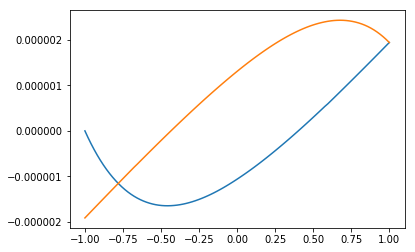

In [1012]:
# bind parameters for the voltage function to make it depend on t only

# define both the forward and reverse sweep functions 
# and discretize to give us the voltage arrays 

# Vinit=1 sweep=.25
vls = partial(voltage_lin_sweep,Vstart,scan_rate)

# discretize v, to give us input V corresponding to q_period
V_forward_array=np.array([vls(t) for t in tt])

# and in reverse
vlsr=partial(voltage_lin_sweep,V_forward_array[timesteps-1],-scan_rate)
V_reverse_array=np.array([vlsr(t) for t in tt])

# pulse from 0 to 3V , between 2 and 3 "sec"
vp  = partial(voltage_pulse,0.,3.,2,3)

# solve it and reshape it back to an array from a 1D vector
q_forward=odeint(param_memdiode,Qstart,tt,args=(vls,))
q_forward=q_forward.reshape(len(tt))

# now, solve the reverse sweep, the boundary condition is the last charge of the forward sweep
q_reverse=odeint(param_memdiode,q_forward[timesteps-1],tt,args=(vlsr,))
q_reverse=q_reverse.reshape(len(tt))

plt.plot(V_forward_array,q_forward)
plt.plot(V_reverse_array,q_reverse)

# lets store the final charge for the reverse sweep

In [1013]:
# C=Q/V
#
# V=Q/C
#
# V kg·m2·s−3·A−1   (or J/C)
#
# single transistor model 
#
def j1_1t(Vc,V):
        
    v1=V-Vc
    
    j = js1 * ( np.exp((e*v1)/(m1*kb*T),dtype=np.float64) - np.exp((e*(v1-V))/(m1*kb*T),dtype=np.float64) ) - jphoto

    return j

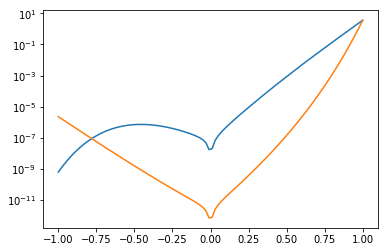

In [1014]:
jf=j1_1t(q_forward/Cion,V_forward_array)
#plt.plot(V_forward_array,jf)
plt.semilogy(V_forward_array,abs(jf))
jr=j1_1t(q_reverse/Cion,V_reverse_array)
#plt.plot(V_reverse_array,jr)
plt.semilogy(V_reverse_array,abs(jr))

In [1015]:
# C=Q/V
#
# V=Q/C
#
# V kg·m2·s−3·A−1   (or J/C)
#
# two transistor transistor model 
#
def j1_2t(Vn,v1,V):
            
    j = js1 * ( np.exp((e*(v1-Vn))/(m1*kb*T),dtype=np.float64) - np.exp((e*(v1-V))/(m1*kb*T),dtype=np.float64) )

    return j

In [1016]:
# C=Q/V
#
# V=Q/C
#
# V kg·m2·s−3·A−1   (or J/C)
#
# two transistor transistor model 
#
def j2_2t(Vn,v2,V):
            
    j = js2 * ( np.exp((e*v2)/(m1*kb*T)) - np.exp((e*(v2-Vn))/(m1*kb*T)) )

    return j

In [1018]:
# j2-j1-jphoto=0
#
def kirchoff(Vn,v1,v2,V,jphoto):
    return j2_2t(Vn,v2,V)-j1_2t(Vn,v1,V)+jphoto

# j is equivalent to simply j2
# first, we need to solve: j2=j1+jphoto for the unknown Vn
# then substitue Vn into expression for j2
#
def solve_for_j(q,V,jphoto,C,v0):
    
    # q array stores charges on the caps (q same accross all caps)
    # V array has input voltages corresponding to charges above 

    v2=q/C
    v1=V-q/C       
    
    v_n=np.array([root(kirchoff,x0=v0,args=(v1[i],v2[i],V[i],jphoto)).x 
                       for i in range(timesteps)]) 
    
    v_n=v_n.reshape(len(tt));
    
    j_array=j2_2t_vec(v_n,v2,V) 
        
#    j_array=np.array([ j2_2t(root(kirchoff,x0=v0,args=(v1[i],v2[i],V[i],jphoto)).x,
#                              v2[i],
#                              V[i]) 
#                       for i in range(timesteps)])    
    return (v_n,j_array)

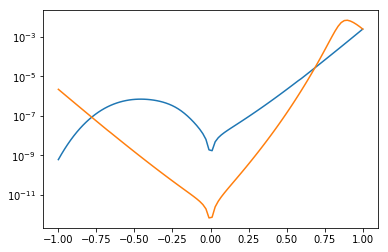

In [1019]:
v0=-.5      # the search for root will start here

(vnf2,jf2)=solve_for_j(q_forward,V_forward_array,jphoto,Cion,v0) #Vn forward 2 transistor , j forward 2 transistor
(vnr2,jr2)=solve_for_j(q_reverse,V_reverse_array,jphoto,Cion,v0)

# this code is here just to help us 
# figure out the starting point for the solver
# by plotting the functions over the a sample of 
# input voltage ranges
#
#i=99
#vnl=np.linspace(v0,0.2,1000,dtype=np.float64)
#res=kirchoff(vnl,v1[i],v2[i],V_array[i])
#plt.plot(vnl,res)

#for i in range(1000):
#    res=root(kirchoff,x0=v0,args=(v1[i],v2[i],V_array[i]))
#    print(V_array[i],j2_2t(res.x,v2[i],V_array[i]))
     

plt.semilogy(V_forward_array,abs(jf2))
plt.semilogy(V_reverse_array,abs(jr2))

#plt.semilogy(V_forward_array,abs(jf))
#plt.semilogy(V_reverse_array,abs(jr))

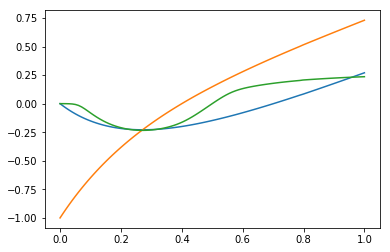

In [1020]:
# plots of v1 and v2 in the forward direction

plt.plot(tt,q_forward/Cion)
plt.plot(tt,V_forward_array-q_forward/Cion)
plt.plot(tt,vnf2)

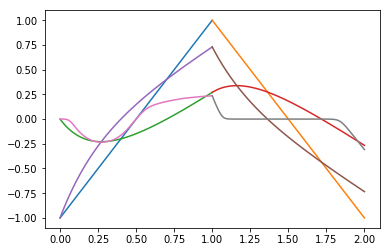

In [1021]:
plt.plot(tt,V_forward_array)
plt.plot(tt+tt[timesteps-1],V_reverse_array)

plt.plot(tt,q_forward/Cion)
plt.plot(tt+tt[timesteps-1],q_reverse/Cion)

plt.plot(tt,V_forward_array-q_forward/Cion)
plt.plot(tt+tt[timesteps-1],V_reverse_array-q_reverse/Cion)

plt.plot(tt,vnf2)
plt.plot(tt+tt[timesteps-1],vnr2)